In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy.linalg import sqrtm
from statsmodels.stats.correlation_tools import cov_nearest
from torchdiffeq import odeint

from ml import KramersMoyal, load_kernels_dict
from neural_ode import ODEfunc, RunningAverageMeter
from plot import ImperialColors, plot_simulation
from potenciala import BucketMethod, VectorTimeSeries
from stochastic import (EulerMaruyama, SpatialNearestDriftMultivariate, ConstantDiffusionMultivariate)

In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load VectorTimeSeries and drift and diffusion coefficients

In [5]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
expected_drift_kde_df = KramersMoyal.obtain_first_coefficient_vector(kernels_dict=d_1_dict)

d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)
second_km_kde_matrix = KramersMoyal.obtain_second_coefficient_matrix(diag_kernels_dict=d_2_diag_dict, 
                                                                     non_diag_kernels_dict=d_2_non_diag_dict)

drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=2*second_km_kde_matrix, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

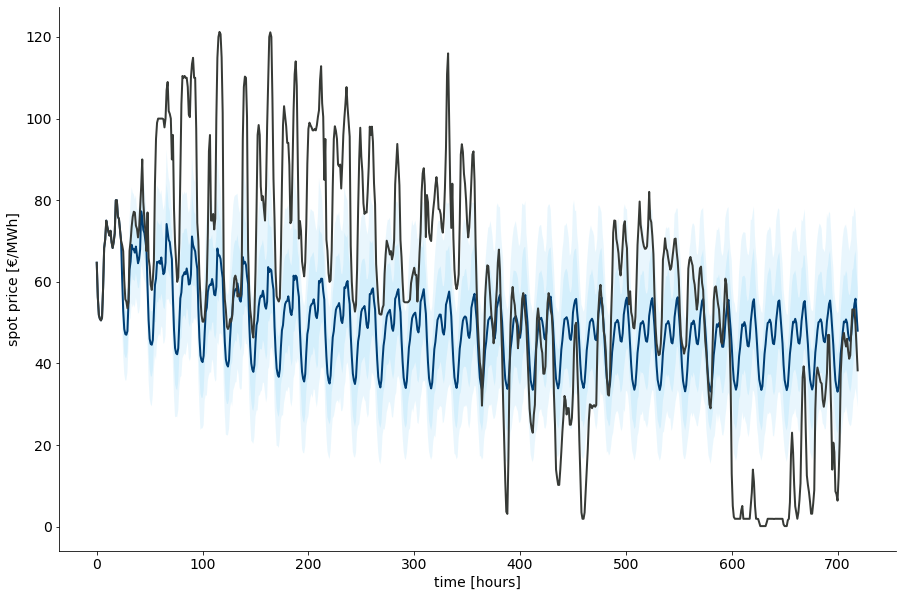

In [6]:
sim_periods = 30
x_df = df_raw[df_raw["date"] >= "2021-01-05"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

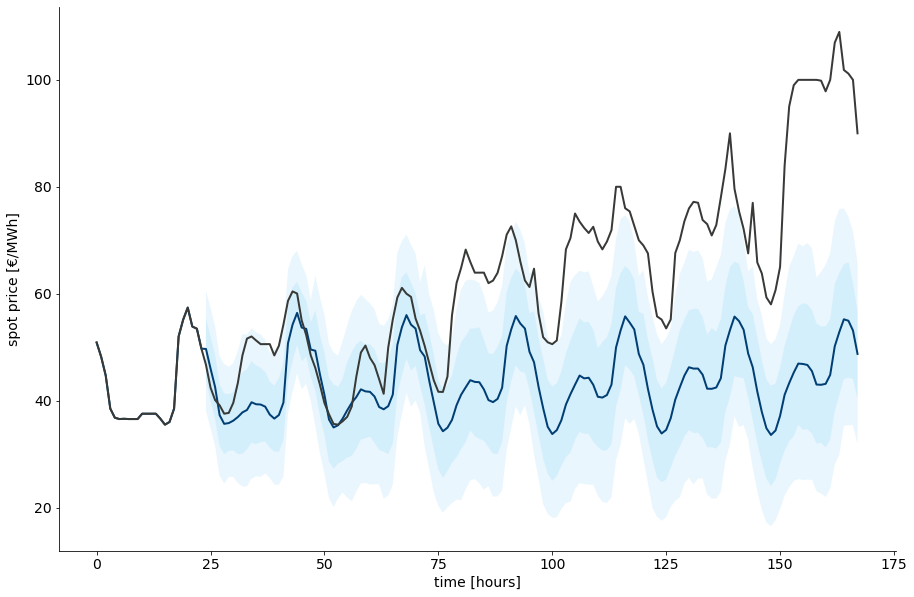

In [7]:
sim_periods = 7
x_df = df_raw[df_raw["date"] >= "2021-01-01"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

### Compute difference between simulation and external drift to generate training set

In [8]:
diff_df = sim_df.subtract(x_df_kde.reset_index()["spain"], axis="index")
diff_df.index = pd.RangeIndex(start=1, stop=diff_df.index.max()+2, step=1)

hour_indexes = np.vstack([np.arange(1, 25, 1) + 24*i for i in range(sim_periods)]).T

In [9]:
hours_list = np.arange(1, 25)
ts = np.arange(0, sim_periods)
multi_idx = pd.MultiIndex.from_product([hours_list, ts])
hour_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)

for i, h in enumerate(hours_list):
    hour_diff_df.loc[h] = diff_df.loc[hour_indexes[i]].values

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_32689/2641513247.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hour_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)


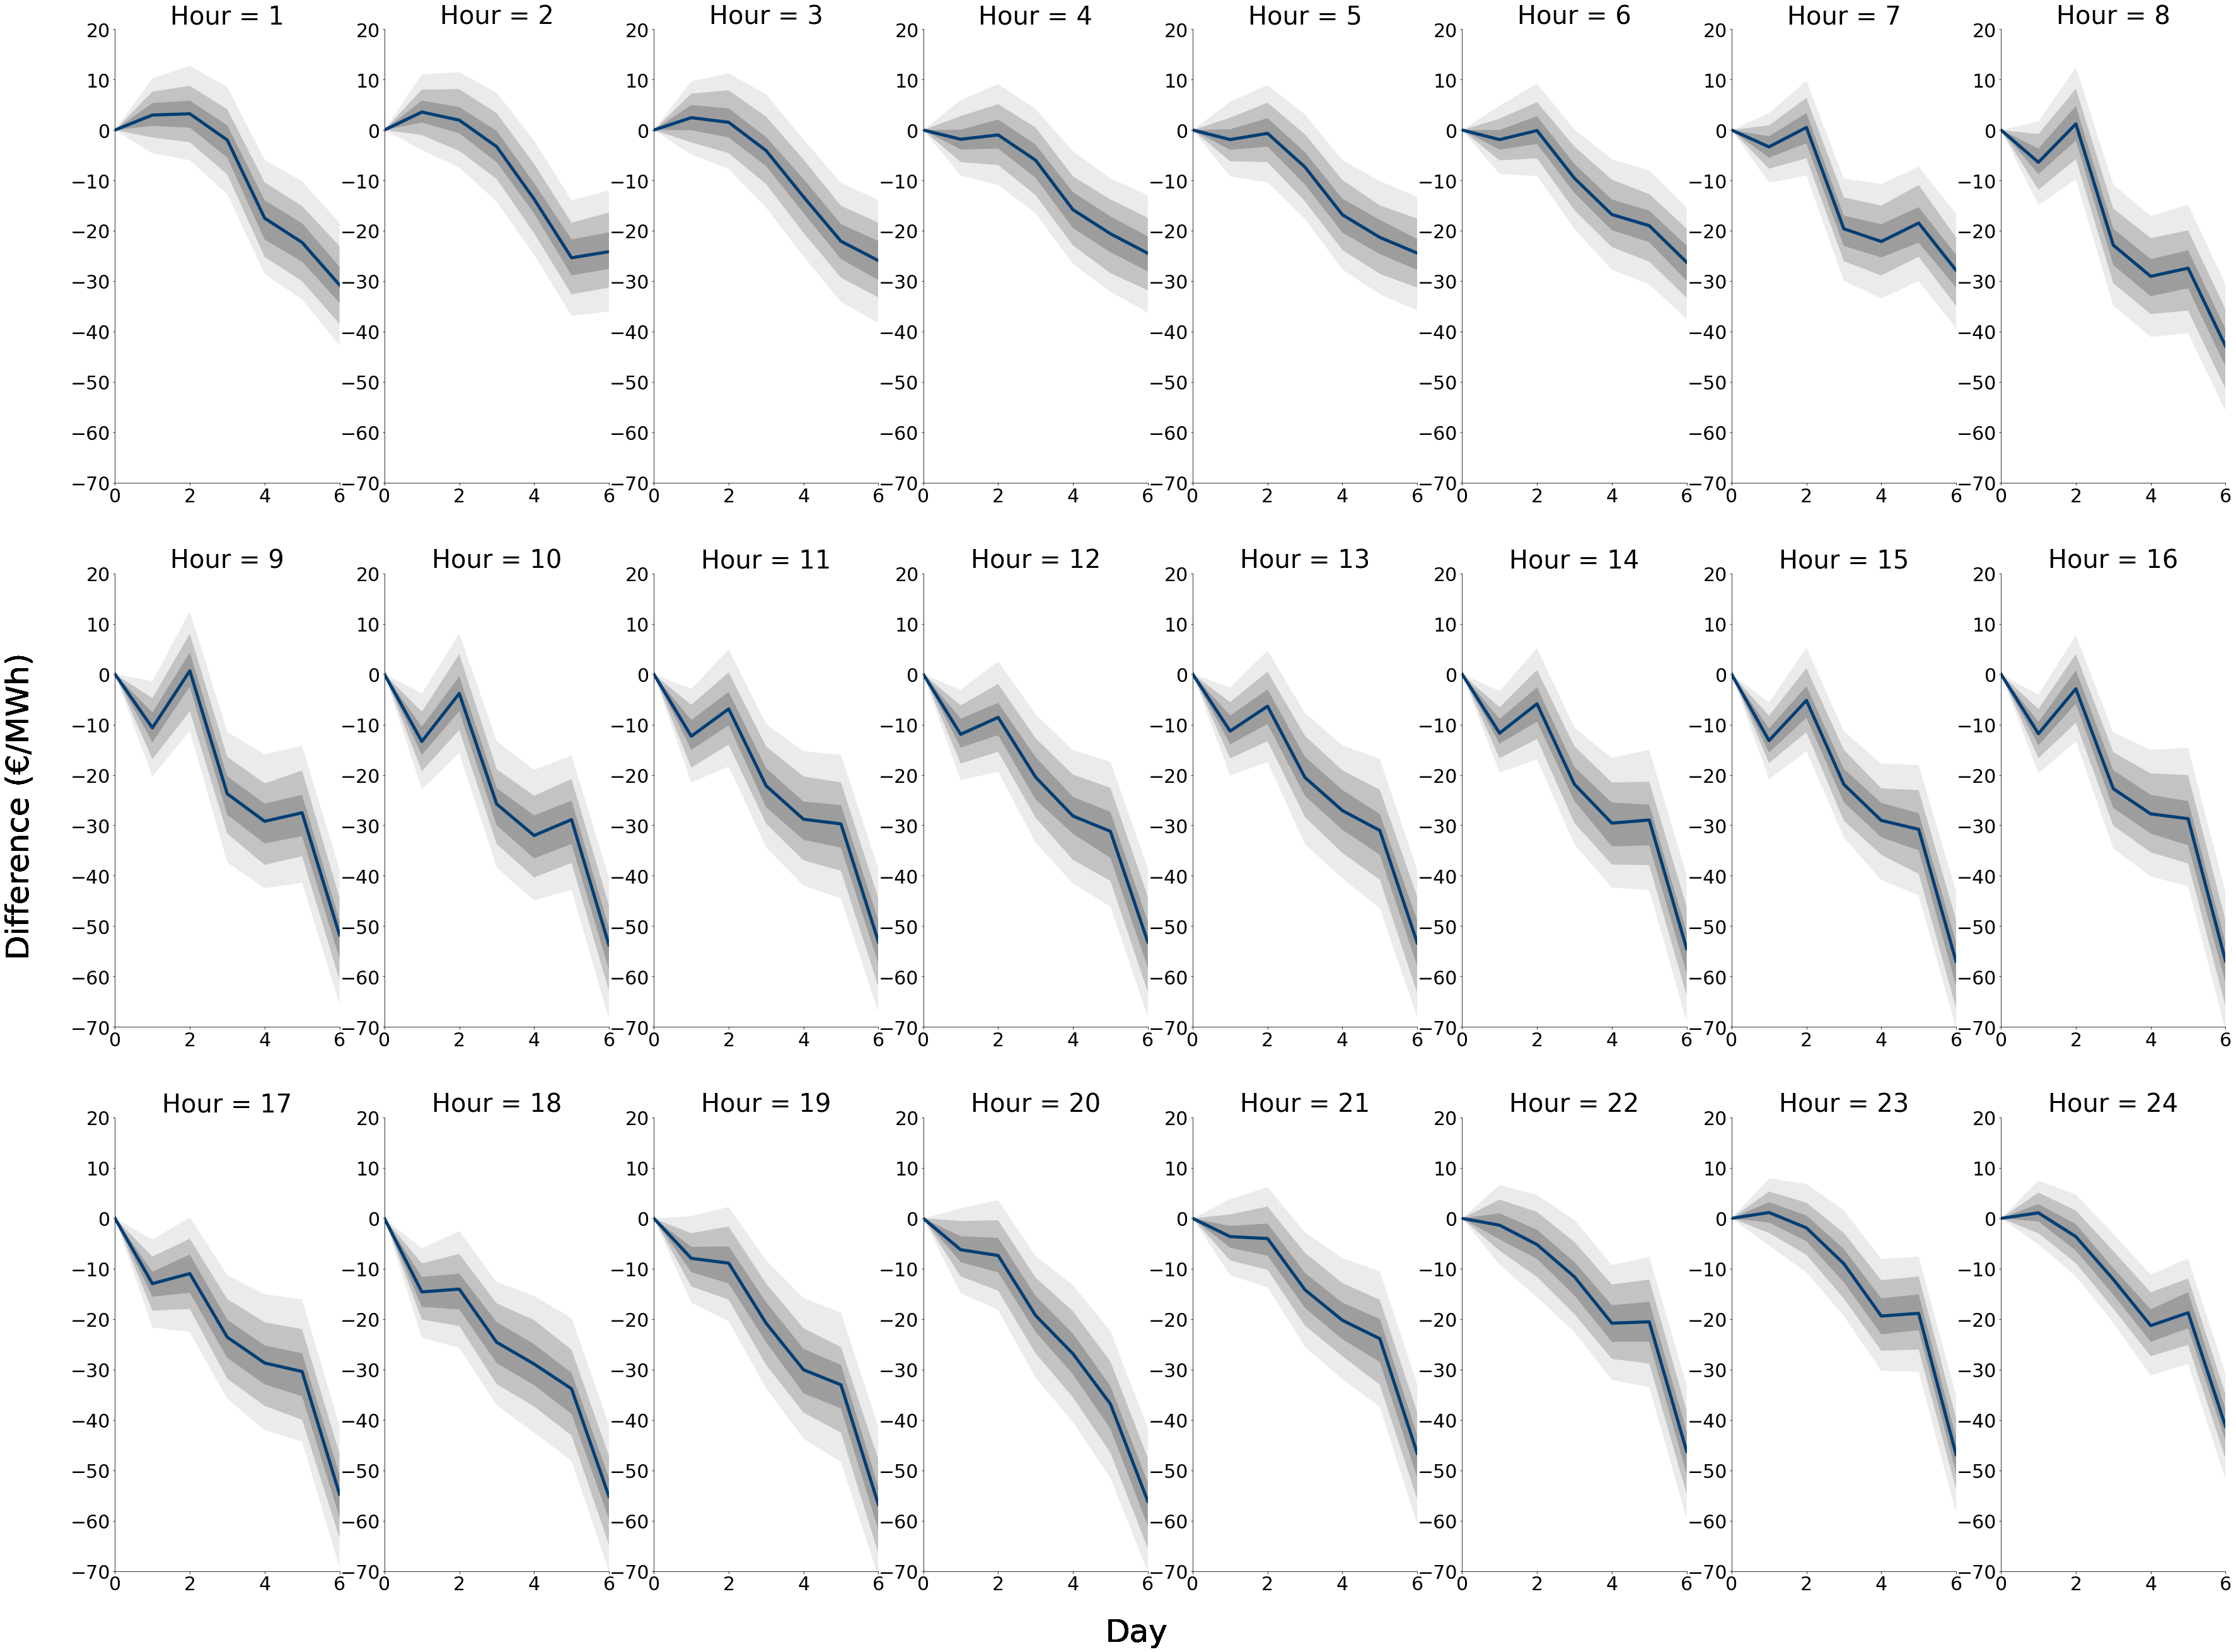

In [10]:
fig, axis = plt.subplots(3, 8, figsize=(60, 45))
percentiles_alpha = [0.2, 0.5, 1]
quantile = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        hour_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        percentile_df = hour_diff_df.loc[h].quantile(q=quantile, axis=1)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                percentile_df.columns, percentile_df.loc[quantile[k]], percentile_df.loc[quantile[-k-1]],
                facecolor=ImperialColors.cool_grey.value, alpha=alpha_value
            )
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 6)
        ax.set_ylim(-70, 20)
        ax.tick_params(axis="both", labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
        fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)

### Train neural ODE to learn external drift

In [257]:
def get_multivariate_batch(train_df: pd.DataFrame, t: int):
    batch_y = np.zeros((t+1, 20, 1, 24)) # shape: (time, batch_size, 1, obs_dim)
    batch_t = torch.from_numpy(np.arange(t+1, dtype=np.float64))
    col_indexes = np.random.choice(train_df.columns, size=20, replace=False) # pick batch_size columns
    # iterate through each timestamp to get array of shape (batch_zise, 1, obs_dim)
    for h in range(t+1):
        batch_y[h] = train_df[col_indexes].xs(h, level=1, drop_level=False).T.values.reshape(20, 1, 24)
    batch_y0 = torch.from_numpy(batch_y[0]).float()
    batch_y = torch.from_numpy(batch_y)
        
    return batch_y0, batch_t, batch_y

In [260]:
device = torch.device("cpu")

init_window_length = 0
time_step = 1

func = ODEfunc(obs_dim=24, hidden_layer_1=48).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for j in range(1, 2):
    trajectory_time = init_window_length + time_step*j
    
    start = time.time()
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    
    for itr in range(3_000):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_multivariate_batch(train_df=hour_diff_df, t=trajectory_time)
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)

        pred_y = odeint(func, batch_y0, batch_t).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())
        end = time.time()
        training_time = (end-start) / 60

        if itr % 100 == 0:
            print(f"Iteration {j}: {itr:04d} | total loss {loss_meter.avg:.6f} | Time: {training_time:.2f} mins")
        
        end = time.time()

Iteration 1: 0000 | total loss 4.781574 | Time: 0.00 mins
Iteration 1: 0100 | total loss 3.902507 | Time: 0.08 mins
Iteration 1: 0200 | total loss 3.781383 | Time: 0.16 mins
Iteration 1: 0300 | total loss 3.811782 | Time: 0.24 mins
Iteration 1: 0400 | total loss 3.841476 | Time: 0.31 mins
Iteration 1: 0500 | total loss 3.792404 | Time: 0.39 mins
Iteration 1: 0600 | total loss 3.801488 | Time: 0.47 mins
Iteration 1: 0700 | total loss 3.784853 | Time: 0.54 mins
Iteration 1: 0800 | total loss 3.820528 | Time: 0.62 mins
Iteration 1: 0900 | total loss 3.777661 | Time: 0.70 mins
Iteration 1: 1000 | total loss 3.826104 | Time: 0.77 mins
Iteration 1: 1100 | total loss 3.793193 | Time: 0.85 mins
Iteration 1: 1200 | total loss 3.794271 | Time: 0.93 mins
Iteration 1: 1300 | total loss 3.791625 | Time: 1.00 mins
Iteration 1: 1400 | total loss 3.788550 | Time: 1.08 mins
Iteration 1: 1500 | total loss 3.766750 | Time: 1.16 mins
Iteration 1: 1600 | total loss 3.797978 | Time: 1.23 mins
Iteration 1: 1

In [263]:
batch_y0.shape

torch.Size([20, 1, 24])

In [271]:
true_y0 = torch.from_numpy(np.zeros((1, 1, 24), dtype=np.float64)).float().to(device)

In [304]:
with torch.no_grad():
    true_t = torch.from_numpy(np.arange(3, dtype=np.float64))
    pred_y = odeint(func, true_y0, true_t)

In [305]:
pred_y

tensor([[[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
             0.0000,   0.0000,   0.0000]]],


        [[[  2.8430,   3.1137,   1.9262,  -2.4676,  -2.2225,  -1.9328,  -3.2970,
            -6.1350, -10.6218, -12.9326, -11.7646, -12.1522, -10.9994, -11.2210,
           -13.0486, -11.6346, -12.9964, -14.8200,  -7.9172,  -5.8156,  -3.5352,
            -0.8894,   1.3369,   1.4786]]],


        [[[  5.8155,   6.3751,   3.9455,  -5.0498,  -4.5451,  -3.9539,  -6.7460,
           -12.5592, -21.7473, -26.4749, -24.0846, -24.8810, -22.5156, -22.9774,
           -26.7138, -23.8158, -26.6085, -30.3346, -16.2096, -11.9049,  -7.2330,
            -1.8236,   2.7384,   3.0249]]]])

In [306]:
hour_diff_df.xs(1, level=1, drop_level=False).mean(axis=1)

1   1     2.974443
2   1     3.566827
3   1     2.450034
4   1    -1.837667
5   1    -1.893509
6   1    -1.904188
7   1    -3.347405
8   1    -6.408067
9   1   -10.656220
10  1   -13.349318
11  1   -12.311709
12  1   -11.928537
13  1   -11.291839
14  1   -11.701048
15  1   -13.180311
16  1   -11.815806
17  1   -12.950326
18  1   -14.595938
19  1    -7.926662
20  1    -6.225994
21  1    -3.624141
22  1    -1.355712
23  1     1.165584
24  1     1.096480
dtype: float64

In [308]:
hour_diff_df.xs(2, level=1, drop_level=False).mean(axis=1)

1   2     3.222011
2   2     1.959565
3   2     1.528731
4   2    -0.976112
5   2    -0.663814
6   2    -0.102598
7   2     0.504906
8   2     1.218714
9   2     0.673132
10  2    -3.819157
11  2    -6.892059
12  2    -8.570200
13  2    -6.361502
14  2    -5.883536
15  2    -5.203639
16  2    -2.895570
17  2   -10.959045
18  2   -14.041654
19  2    -8.887471
20  2    -7.367184
21  2    -4.005836
22  2    -5.195386
23  2    -1.885479
24  2    -3.623494
dtype: float64